In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pickle

import os
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import random
from collections import deque

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

# PinSAGE
- Pinterest의 GraphSAGE 개선 

## 제시한 cluster 기준

In [ ]:
# 평가(voted up)에 따라 rating을 0/1로 구분

ratings_df = pd.read_csv("rating_df.csv")
ratings_df = ratings_df.groupby('userId').filter(lambda x: len(x) > 7)
ratings_df

,userId,gameId,rating,timestamp,clusters
20,76561197960268768,1097840,0,0,1
21,76561197960268768,601150,1,1,2
22,76561197960268768,1240440,0,2,1
23,76561197960268768,985890,1,3,2
24,76561197960268768,1369760,1,4,4
...,...,...,...,...,...
1924383,76561199389837504,1599340,1,6,1
1924384,76561199389837504,1316230,1,7,4
1924385,76561199389837504,219990,1,8,2
1924386,76561199389837504,1063730,1,9,1


In [ ]:
game_df = ratings_df.drop(['userId', 'rating', 'timestamp'],axis = 1)

game_df.drop_duplicates(inplace = True)
ratings_df.drop(['clusters'], axis = 1, inplace = True)

game_df.columns = ['gameId', 'genre']

In [ ]:
class Config:
    data_path = './pinsage/' 
    model_path = './model/'
    model_name = 'PinSage'
    
    hidden_dim = 64
    neighborhood_nums = [3, 3]   # [3]
    K = 2                        # K = 1

    lr = 0.001
    epochs = 30
    batch_size = 128
    num_workers = 4
    seed = 42

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    total_items = None
    input_dim = None

config = Config()

In [ ]:
print(len(game_df))
game_df = game_df[game_df['gameId'].isin(ratings_df.gameId)]
print(len(game_df))

3890
3890


In [ ]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
# 데이터 로드

ratings = ratings_df
ratings = ratings.sort_values(['userId', 'timestamp']).reset_index(drop = True)
ratings['userId'] = ratings['userId'].astype(str)
ratings['gameId'] = ratings['gameId'].astype(str)

games = game_df
games['gameId'] = games['gameId'].astype(str)

In [ ]:
# 데이터 전처리

def get_column_to_idx_and_idx_to_column(df : pd.DataFrame, column : str):
    column_to_idx = {}
    idx_to_column = {}

    item_list = df[column].unique()

    for idx, item in enumerate(item_list):
        column_to_idx[item] = idx
        idx_to_column[idx] = item
    
    return column_to_idx, idx_to_column

userId_to_idx, idx_to_userId = get_column_to_idx_and_idx_to_column(df=ratings, column='userId')
gameId_to_idx, idx_to_gameId = get_column_to_idx_and_idx_to_column(df=games, column='gameId')

ratings['pre_userId'] = ratings['userId'].apply(lambda x : userId_to_idx[x])
ratings['pre_gameId'] = ratings['gameId'].apply(lambda x : gameId_to_idx[x])

games['pre_gameId'] = games['gameId'].apply(lambda x : gameId_to_idx[x])
games = games.sort_values('pre_gameId').reset_index(drop = True)


config.total_items = games['pre_gameId'].tolist()

In [ ]:
# feature 생성

games['genres_list'] = games['genre'].apply(lambda  x : str(x).split(','))

total_genres = []

genres_list = games['genres_list'].tolist()
for genres in genres_list:
    total_genres += genres

total_genres = list(set(total_genres))

genre_to_idx = {}

for idx, genre in enumerate(total_genres):
    genre_to_idx[genre] = idx

games['pre_genres_list'] = games['genres_list'].apply(lambda  x : [genre_to_idx[i] for i in x])

feature = np.zeros((len(games), len(total_genres)))
for movie in games.iloc:
    feature[movie['pre_gameId'], movie['pre_genres_list']] = 1

feature = torch.tensor(feature, dtype = torch.float32)
config.input_dim = len(total_genres)

In [ ]:
genre_to_idx

{'4': 0, '0': 1, '5': 2, '1': 3, '3': 4, '7': 5, '2': 6, '6': 7}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df : pd.DataFrame, total_items : list, K : int, neighborhood_nums : list, train : bool = True):

        self.movie_to_user = self.get_A_to_B(df = ratings, A = 'pre_gameId', B = 'pre_userId')
        self.user_to_movie = self.get_A_to_B(df = ratings, A = 'pre_userId', B = 'pre_gameId')
        self.target_nodes = sorted(df['pre_gameId'].unique().tolist())

        self.total_items = total_items
        self.K = K
        self.neighborhood_nums = neighborhood_nums
        self.train = train

    def get_A_to_B(self, df : pd.DataFrame, A : str, B : str):
        A_to_B = {}
        A_group_df = df.groupby(A)
        for A_id, A_g_d in A_group_df:
            A_to_B[A_id] = A_g_d[B].tolist()
    
        return A_to_B

    def get_subgraph(self, K : int, neighborhood_nums : list, target_node : int, node_to_edge : dict, edge_to_node : dict):
        num_nodes = 1
        for i in range(K):
            if i == 0: num_nodes += neighborhood_nums[i]
            else: num_nodes += neighborhood_nums[i - 1] * neighborhood_nums[i]
        
        # Random_Walk
        edges = []
        nodes = [target_node]
        node_to_node = []

        q = deque([[target_node, 1]])
        
        while q:
            now_node, depth = q.popleft()
            if depth > K:
                continue
            for _ in range(neighborhood_nums[depth - 1]):
                edge = random.choice(node_to_edge[now_node])
                next_node = random.choice(edge_to_node[edge])
                
                while (next_node in nodes):
                    edge = random.choice(node_to_edge[now_node])
                    next_node = random.choice(edge_to_node[edge])

                edges.append(edge)
                nodes.append(next_node)
                node_to_node.append((now_node, next_node))

                q.append([next_node, depth + 1])

        # subgraph 생성 -> adj
        node_to_idx = {node : idx for idx, node in enumerate(nodes)}
        adj = np.zeros((num_nodes, num_nodes))

        for now_node, next_node in node_to_node:
            adj[node_to_idx[now_node], node_to_idx[next_node]] = 1
            adj[node_to_idx[next_node], node_to_idx[now_node]] = 1

        return nodes, node_to_idx[target_node], adj, edges, num_nodes

    def __len__(self):
        return len(self.target_nodes)
    
    def __getitem__(self, idx):
        target_node = self.target_nodes[idx]
        
        nodes, target_node, adj, users, num_nodes = self.get_subgraph(K = self.K, neighborhood_nums=self.neighborhood_nums, target_node=target_node, node_to_edge=self.movie_to_user, edge_to_node=self.user_to_movie)

        if self.train:
            pos_items = []
            for user in users:
                pos_items += self.user_to_movie[user]
            query_nodes, _, _, _, _ = self.get_subgraph(K = self.K, neighborhood_nums=self.neighborhood_nums, target_node=random.choice(pos_items), node_to_edge=self.movie_to_user, edge_to_node=self.user_to_movie)

            neg_items = list(set(self.total_items) - set(pos_items))
            
            if len(neg_items) < num_nodes - 1:
                neg_nodes = [target_node] + np.random.choice(neg_items, num_nodes - 1, replace = True).tolist()
            else:
                neg_nodes = [target_node] + np.random.choice(neg_items, num_nodes - 1, replace = False).tolist()
            
            return {"train":self.train, "target_node":target_node, "adj":adj, "pos_nodes":nodes, "neg_nodes":neg_nodes, "query_nodes": query_nodes}
        
        return {"train":self.train, "nodes":nodes, "target_node":target_node, "adj":adj}

In [ ]:
def make_collate_fn(samples):
    train = samples[0]['train']
    if train:
        pos_nodes = []
        neg_nodes = []
        query_nodes = []
        target_nodes = []
        adj = []

        for sample in samples:
            pos_nodes += [sample['pos_nodes']]
            neg_nodes += [sample['neg_nodes']]
            query_nodes += [sample['query_nodes']]
            target_nodes += [sample['target_node']]
            adj += [sample['adj']]

        return {
            'pos_nodes' : torch.tensor(pos_nodes, dtype = torch.long), 
            'neg_nodes': torch.tensor(neg_nodes, dtype = torch.long),
            'query_nodes': torch.tensor(query_nodes, dtype = torch.long),
            'target_nodes': target_nodes,
            'adj': torch.tensor(adj, dtype = torch.float32),
            }

    else:
        nodes = []
        target_nodes = []
        adj = []

        for sample in samples:
            nodes += [sample['nodes']]
            target_nodes += [sample['target_node']]
            adj += [sample['adj']]

        return {
            'nodes' : torch.tensor(nodes, dtype = torch.long), 
            'target_nodes': target_nodes,
            'adj': torch.tensor(adj, dtype = torch.float32),
            }

In [ ]:
# 모델

class MeanPoolingAggregator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MeanPoolingAggregator, self).__init__()
        self.W = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
    
    def forward(self, adj, x):
        output = torch.bmm(adj, x) / adj.sum(dim = 2).unsqueeze(2)
        output = self.W(output)
        output = self.activation(output)
        return output

class GraphSAGELayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphSAGELayer, self).__init__()
        self.Aggregator = MeanPoolingAggregator(input_dim, hidden_dim)
        self.W = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.activation = nn.ReLU()
    
    def forward(self, adj, x):
        output = self.Aggregator(adj, x)
        output = torch.concat([x, output], dim = -1)
        output = self.W(output)
        output = self.activation(output)
        output = output / torch.linalg.norm(output, dim = 2).unsqueeze(2)
        return output

class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, K):
        super(GraphSAGE, self).__init__()
        layers = []
        for _ in range(K):
            input_dim = input_dim
            layers.append(GraphSAGELayer(input_dim, hidden_dim))
            input_dim = hidden_dim
            hidden_dim = hidden_dim
        self.layers = nn.ModuleList(layers)
        self.G1 = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.activation = nn.ReLU()
        self.G2 = nn.Linear(hidden_dim, hidden_dim, bias=False)
    
    def forward(self, nodes, adj, feature):
        output = feature[nodes]
        for layer in self.layers:
            output = layer(adj, output)
        output = self.activation(self.G1(output))
        output = self.G2(output)
        return output

class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, K):
        super(MyModel, self).__init__()
        self.W = nn.Linear(input_dim, hidden_dim, bias=False) # sparse한 장르 vector를 dense하게 만들기 위해서 W 추가
        self.graph_sage = GraphSAGE(hidden_dim, hidden_dim, K)
    
    def forward(self, pos_nodes, neg_nodes, query_nodes, target_nodes, adj, feature, margin = 1):
        feature = self.W(feature)
        
        pos_output = self.graph_sage(pos_nodes, adj, feature)
        neg_output = self.graph_sage(neg_nodes, adj, feature)
        query_output = self.graph_sage(query_nodes, adj, feature)
        
        pos = pos_output[[i for i in range(len(target_nodes))], target_nodes, :]
        neg = neg_output[[i for i in range(len(target_nodes))], target_nodes, :]
        query = query_output[[i for i in range(len(target_nodes))], target_nodes, :]

        pos = torch.sum(query * pos, dim = 1)
        neg = torch.sum(query * neg, dim = 1)

        return (neg - pos + margin).clamp(min = 0).mean() # 0에 가까워짐
    
    def predict(self, nodes, target_nodes, adj, feature):
        feature = self.W(feature)
        output = self.graph_sage(nodes, adj, feature)
        return output[[i for i in range(len(target_nodes))], target_nodes, :]

In [ ]:
# 학습 함수

def train(model, optimizer, dataloader, feature, device):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        loss = model(pos_nodes=data['pos_nodes'].to(device), neg_nodes=data['neg_nodes'].to(device), query_nodes=data['query_nodes'].to(device), target_nodes=data['target_nodes'], adj=data['adj'].to(device), feature=feature.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    total_loss /= len(dataloader)

    return total_loss

def generate_embedding(model, dataloader, feature, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for data in dataloader:
            embedding = model.predict(nodes=data['nodes'].to(device), target_nodes=data['target_nodes'], adj=data['adj'].to(device), feature=feature.to(device))
            embeddings.append(embedding.cpu().numpy())
    
    return embeddings

In [ ]:
# 학습

train_dataset = CustomDataset(df = ratings, total_items=config.total_items, K=config.K, neighborhood_nums=config.neighborhood_nums, train=True)
train_dataloader = DataLoader(
        train_dataset, 
        batch_size = config.batch_size, 
        shuffle = True, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

valid_dataset = CustomDataset(df = ratings, total_items=config.total_items, K=config.K, neighborhood_nums=config.neighborhood_nums, train=False)
valid_dataloader = DataLoader(
        valid_dataset, 
        batch_size = config.batch_size, 
        shuffle = False, 
        drop_last = False,
        collate_fn = make_collate_fn,
        num_workers = config.num_workers)

seed_everything(seed=config.seed)
model = MyModel(input_dim=config.input_dim, hidden_dim=config.hidden_dim, K=config.K).to(config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [ ]:
model

MyModel(
  (W): Linear(in_features=8, out_features=64, bias=False)
  (graph_sage): GraphSAGE(
    (layers): ModuleList(
      (0): GraphSAGELayer(
        (Aggregator): MeanPoolingAggregator(
          (W): Linear(in_features=64, out_features=64, bias=True)
          (activation): ReLU()
        )
        (W): Linear(in_features=128, out_features=64, bias=True)
        (activation): ReLU()
      )
    )
    (G1): Linear(in_features=64, out_features=64, bias=True)
    (activation): ReLU()
    (G2): Linear(in_features=64, out_features=64, bias=False)
  )
)

In [ ]:
best_loss = 987654321

for epoch in range(1, config.epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
            train_loss = train(model=model, optimizer=optimizer, dataloader=train_dataloader, feature=feature, device=config.device)
            if train_loss < best_loss:
                best_epoch = epoch
                best_loss = train_loss
                torch.save(model.state_dict(), os.path.join(config.model_path, config.model_name + '.pt'))

            tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}')

print(f'BEST | Epoch: {best_epoch:3d}| Train loss: {best_loss:.5f}')

Epoch:   1| Train loss: 0.35317: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it]
Epoch:   2| Train loss: 0.00518: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]
Epoch:   3| Train loss: 0.00622: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
Epoch:   4| Train loss: 0.00336: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]
Epoch:   5| Train loss: 0.00282: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]
Epoch:   6| Train loss: 0.00310: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]
Epoch:   7| Train loss: 0.00308: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]
Epoch:   8| Train loss: 0.00542: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]
Epoch:   9| Train loss: 0.00512: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]
Epoch:  10| Train loss: 0.00651: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]
Epoch:  11| Train loss: 0.00466: 100%|██████████| 1/1 [00:02<00:00,  2.66s/it]
Epoch:  12| Train loss: 0.00487: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]
Epoch:  13| Train loss: 0.00593: 100%|██████████| 1/

BEST | Epoch:  19| Train loss: 0.00173


In [ ]:
model.load_state_dict(torch.load(os.path.join(config.model_path, config.model_name + '.pt')))
item_embeddings = np.concatenate(generate_embedding(model=model, dataloader=valid_dataloader, feature=feature, device=config.device))

print(game_df.shape)
print(item_embeddings.shape)

(3890, 3)
(3890, 64)


### 1단계 : 게임과 게임 연결 하나로 분석

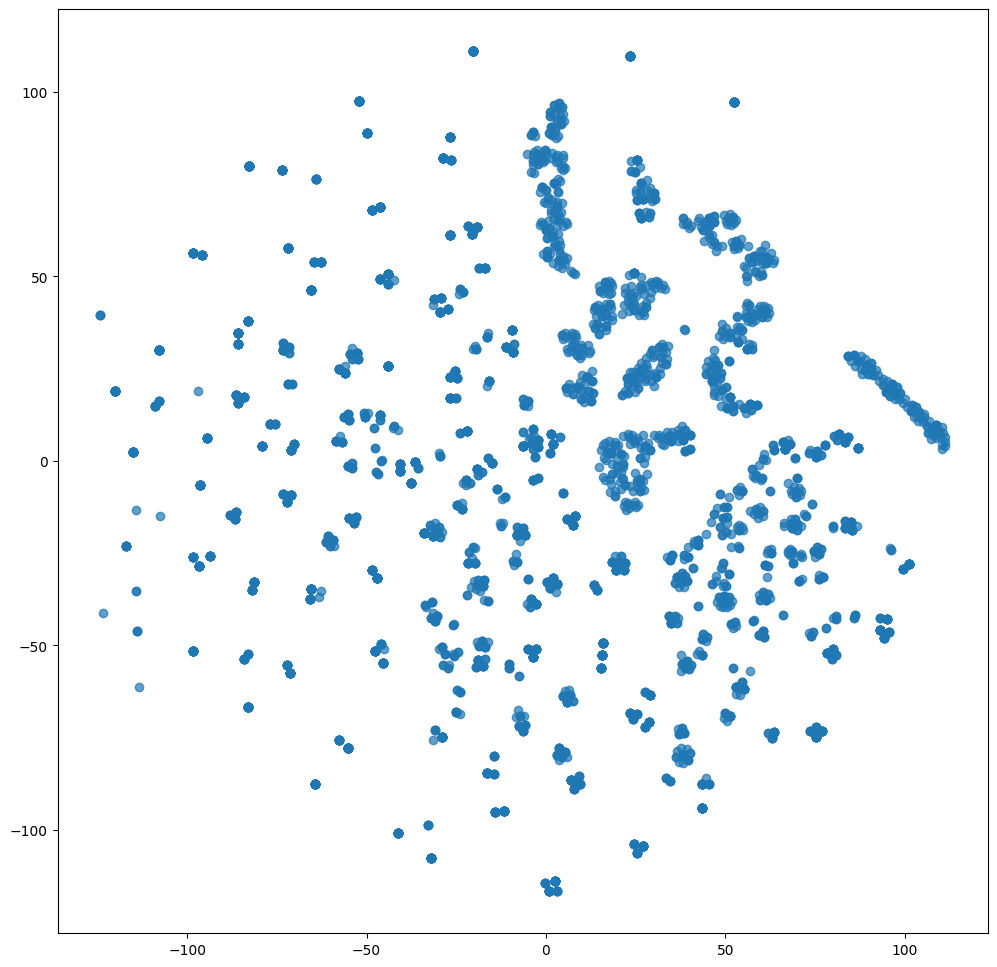

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(item_embeddings)

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(x = tsne_vectors[:, 0], y = tsne_vectors[:, 1], alpha = 0.7) 
plt.show()

In [ ]:
cluster_labels = list(games['genre'])
cluster_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow', 'magenta']

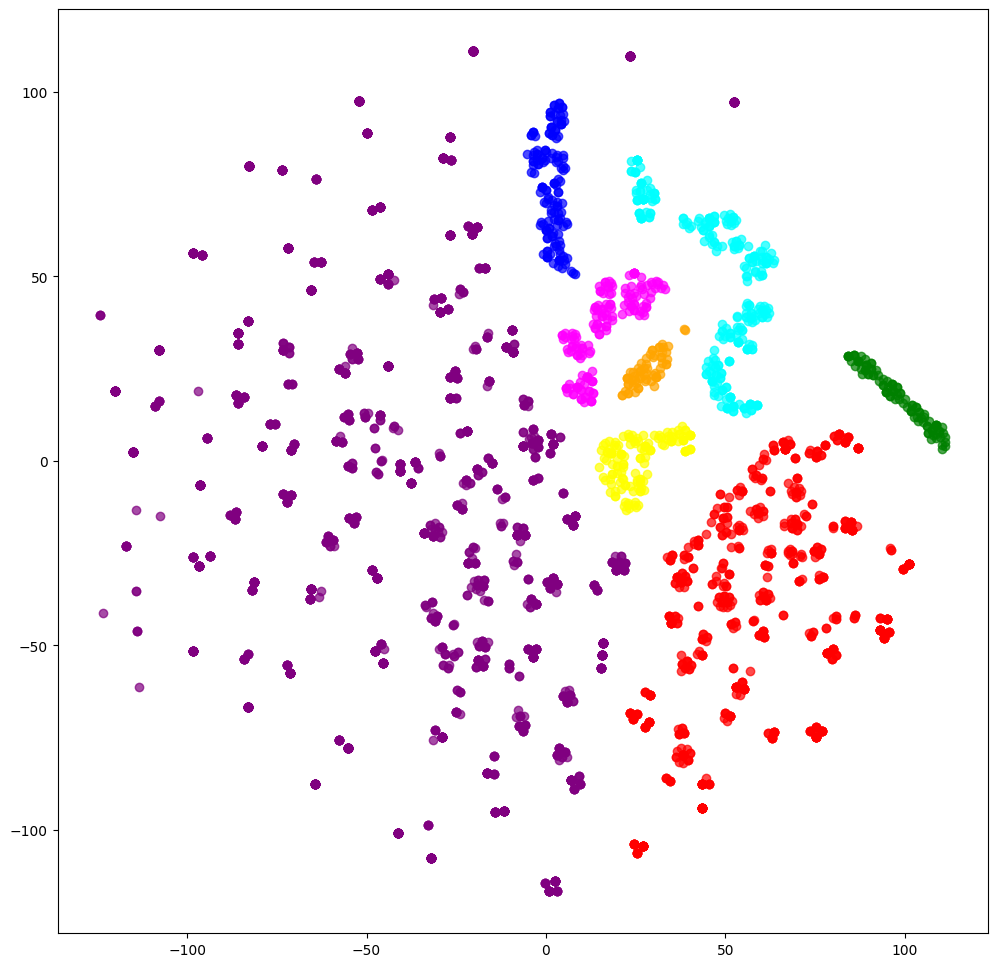

In [ ]:
plt.figure(figsize=(12, 12))
for cluster_label in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_label)
    plt.scatter(
        x=tsne_vectors[cluster_indices, 0],
        y=tsne_vectors[cluster_indices, 1],
        color=cluster_colors[cluster_label],
        alpha=0.7
    )
plt.show()

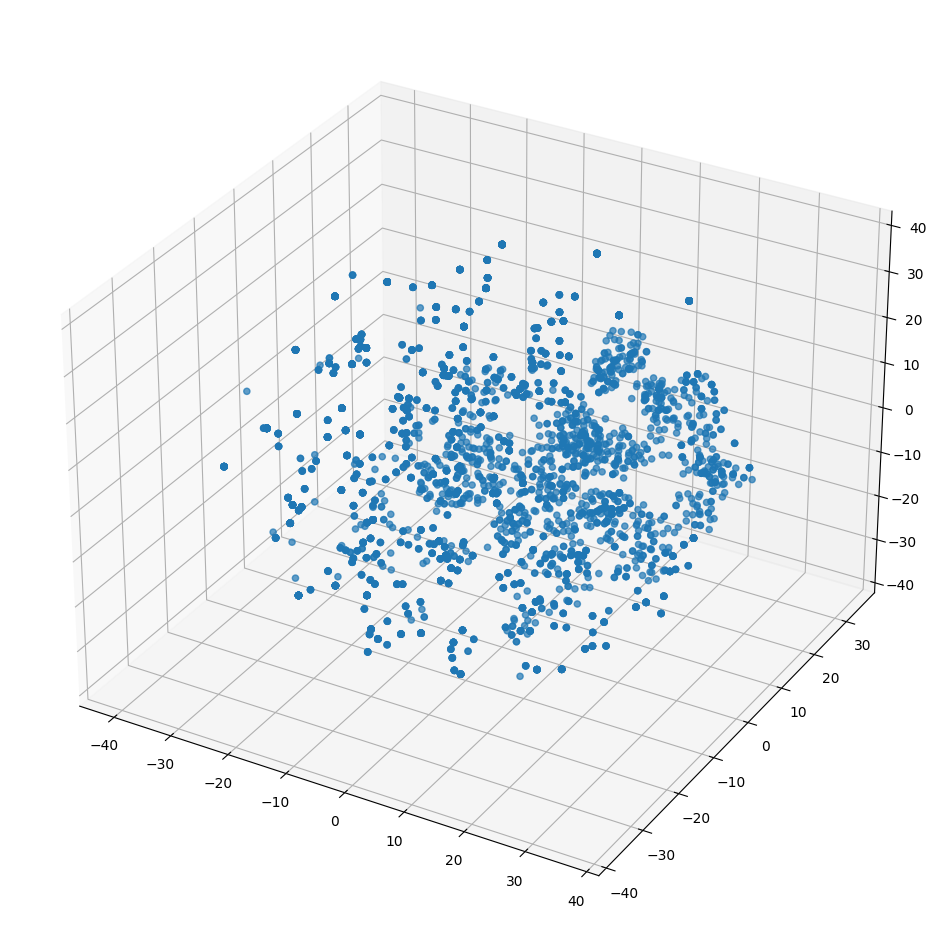

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, random_state=0)
tsne_vectors = tsne.fit_transform(item_embeddings)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=tsne_vectors[:, 0], ys=tsne_vectors[:, 1], zs=tsne_vectors[:, 2], alpha=0.7)
plt.show()

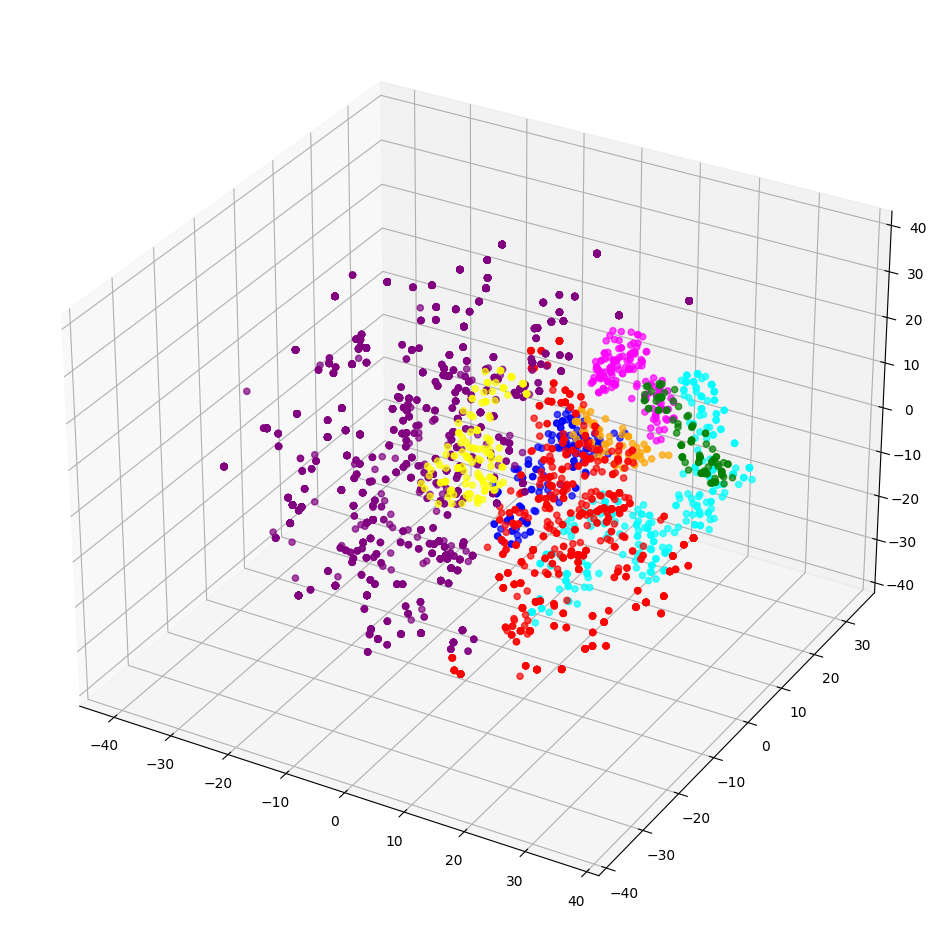

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for cluster_label in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_label)
    ax.scatter(
        xs=tsne_vectors[cluster_indices, 0],
        ys=tsne_vectors[cluster_indices, 1],
        zs=tsne_vectors[cluster_indices, 2],
        color=cluster_colors[cluster_label],
        alpha=0.7
    )
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for cluster_label in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_label)
    ax.scatter(
        xs=tsne_vectors[cluster_indices, 0],
        ys=tsne_vectors[cluster_indices, 1],
        zs=tsne_vectors[cluster_indices, 2],
        color=cluster_colors[cluster_label],
        alpha=0.7
    )

ax.view_init(elev=30, azim=-120)
plt.show()

### 2단계 : 게임과 게임 연결 두 개로 분석

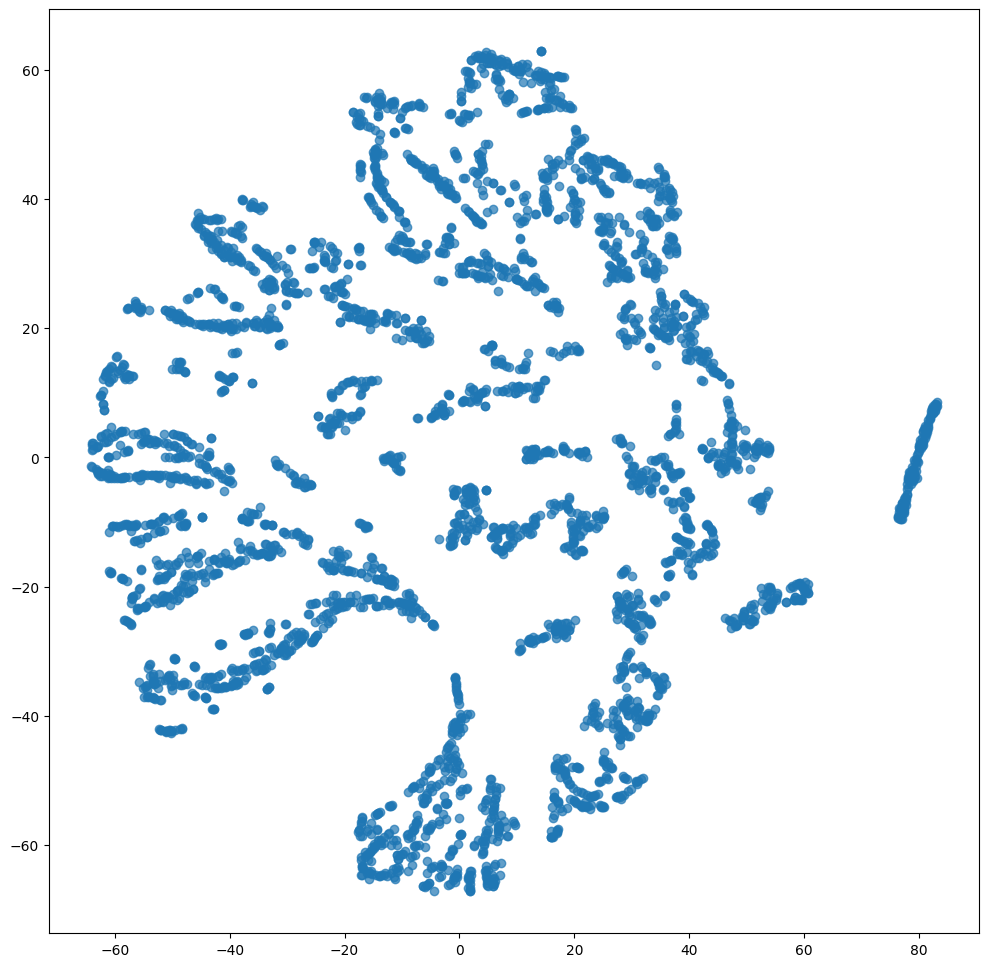

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(item_embeddings)

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))
plt.scatter(x = tsne_vectors[:, 0], y = tsne_vectors[:, 1], alpha = 0.7) 
plt.show()

In [ ]:
cluster_labels = list(games['genre'])
cluster_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow', 'magenta']

In [ ]:
games

,gameId,genre,pre_gameId,genres_list,pre_genres_list
0,1097840,1,0,[1],[4]
1,601150,2,1,[2],[2]
2,1240440,1,2,[1],[4]
3,985890,2,3,[2],[2]
4,1369760,4,4,[4],[0]
...,...,...,...,...,...
3885,1461600,4,3885,[4],[0]
3886,1403020,4,3886,[4],[0]
3887,2262770,4,3887,[4],[0]
3888,1336560,4,3888,[4],[0]


In [ ]:
cluster_labels[:10]

[1, 2, 1, 2, 4, 5, 1, 5, 6, 2]

In [ ]:
np.unique(cluster_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
cluster_colors

['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow', 'magenta']

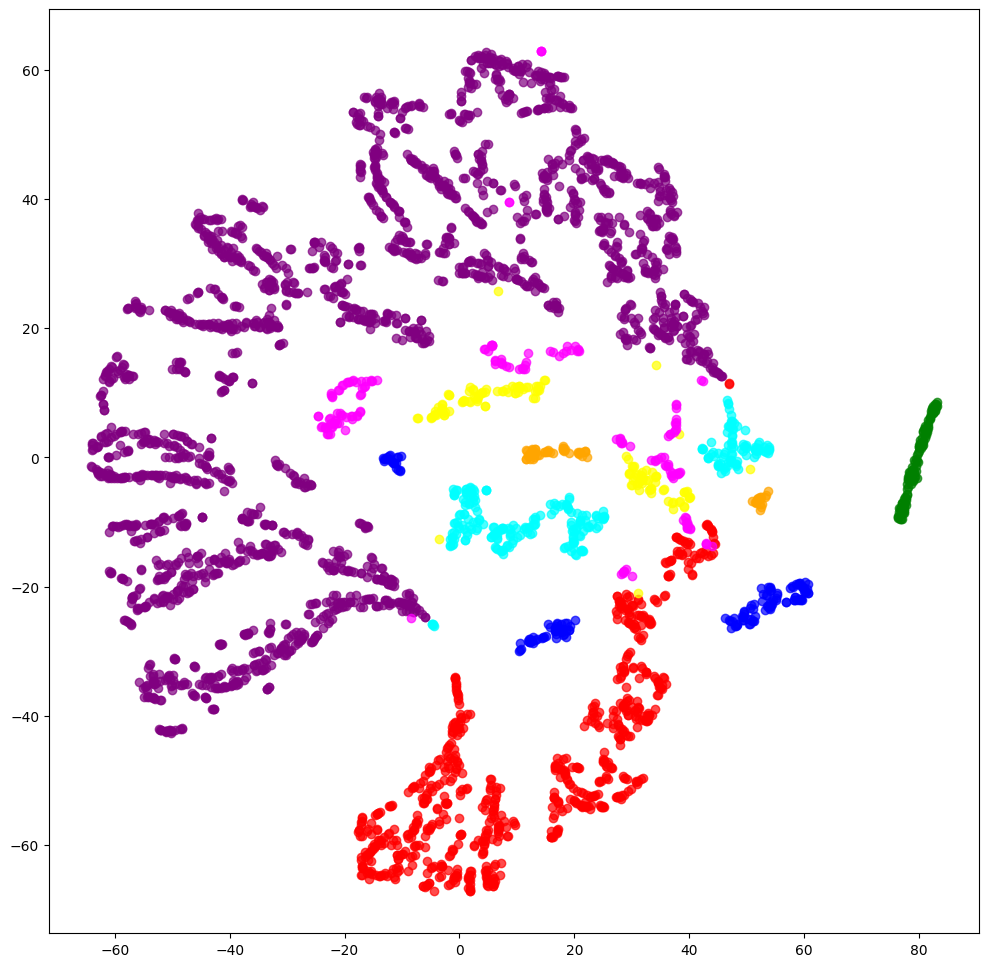

In [ ]:
plt.figure(figsize=(12, 12))
for cluster_label in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_label)
    plt.scatter(
        x=tsne_vectors[cluster_indices, 0],
        y=tsne_vectors[cluster_indices, 1],
        color=cluster_colors[cluster_label],
        alpha=0.7
    )
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, random_state=0)
tsne_vectors = tsne.fit_transform(item_embeddings)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=tsne_vectors[:, 0], ys=tsne_vectors[:, 1], zs=tsne_vectors[:, 2], alpha=0.7)
plt.show()

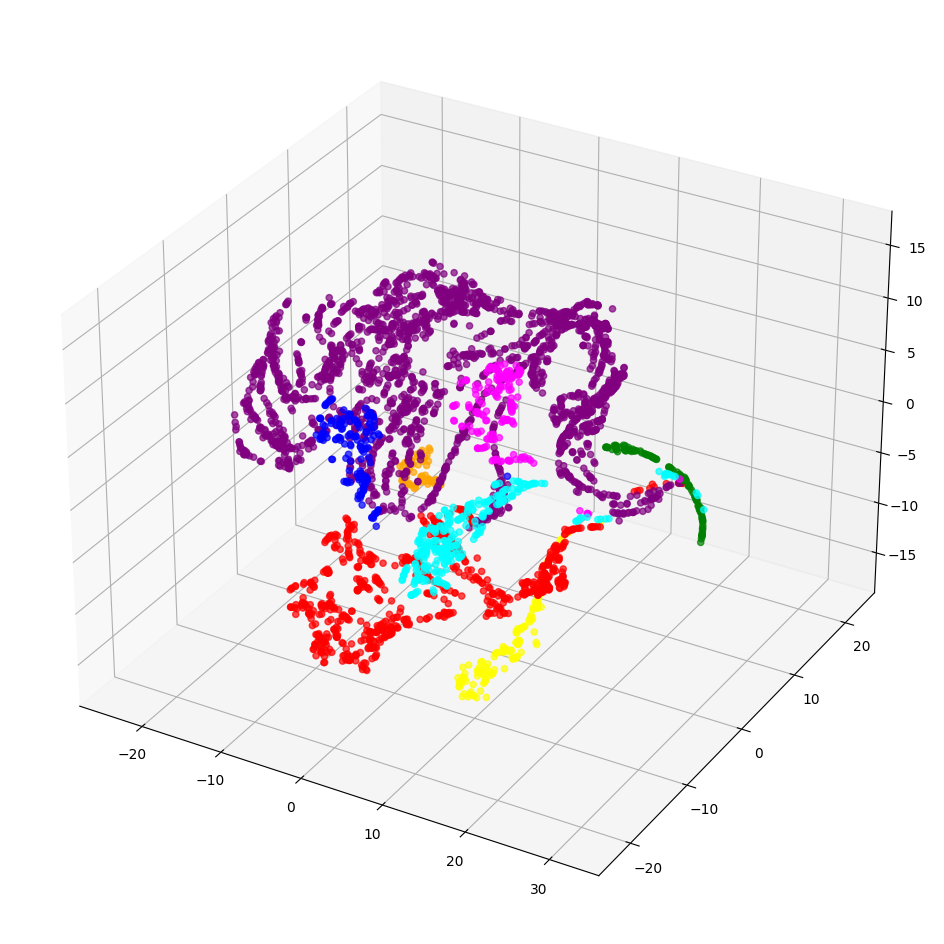

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for cluster_label in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_label)
    ax.scatter(
        xs=tsne_vectors[cluster_indices, 0],
        ys=tsne_vectors[cluster_indices, 1],
        zs=tsne_vectors[cluster_indices, 2],
        color=cluster_colors[cluster_label],
        alpha=0.7
    )
plt.show()

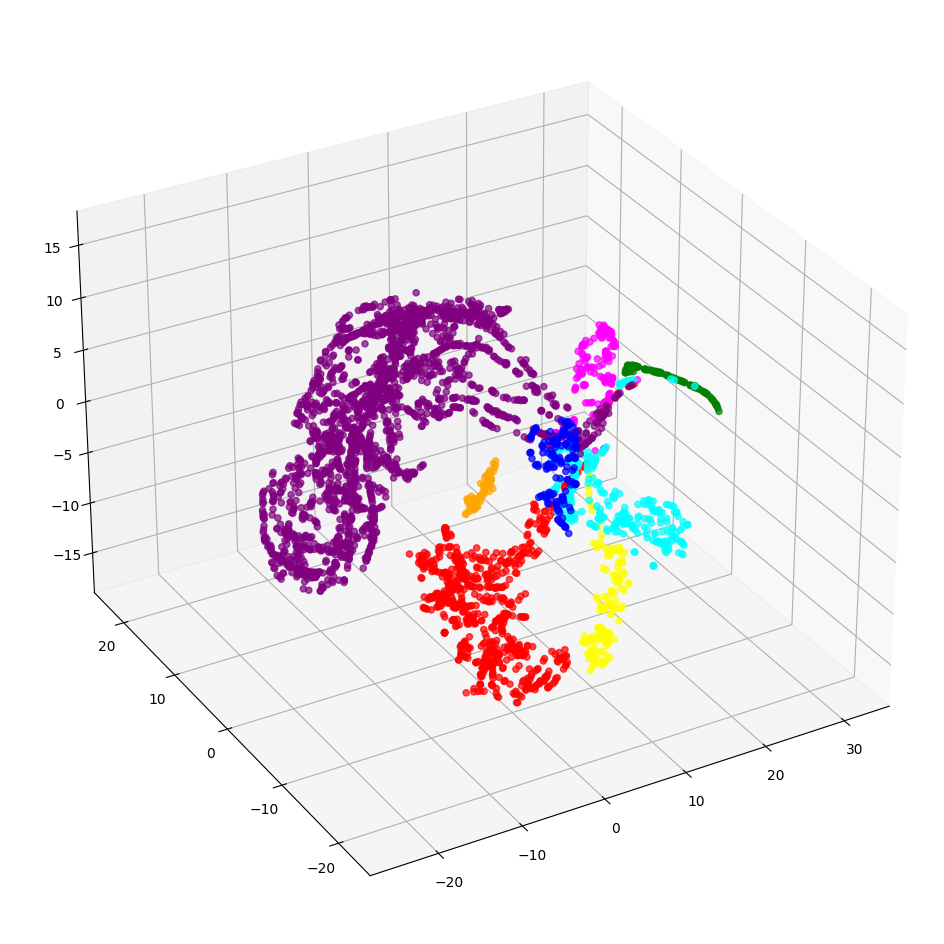

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for cluster_label in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_label)
    ax.scatter(
        xs=tsne_vectors[cluster_indices, 0],
        ys=tsne_vectors[cluster_indices, 1],
        zs=tsne_vectors[cluster_indices, 2],
        color=cluster_colors[cluster_label],
        alpha=0.7
    )

ax.view_init(elev=30, azim=-120)
plt.show()

### 게임 추천 예시 : 직전 게임과 가장 유사한 게임

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

target_nodes = valid_dataloader.dataset.target_nodes

node_to_idx = {}
idx_to_node = {}

for idx, target_node in enumerate(target_nodes):
    node_to_idx[target_node] = idx
    idx_to_node[idx] = target_node

sim_vector = cosine_similarity(item_embeddings[[node_to_idx[gameId_to_idx['970570']]]], item_embeddings)[0]
rec_list = np.argsort(sim_vector)[::-1][:11]
rec_list = [idx_to_gameId[idx_to_node[rec]] for rec in rec_list]
games.set_index('gameId').loc[rec_list, :]

,genre,pre_gameId,genres_list,pre_genres_list
gameId,,,,
970570,0,632,[0],[5]
1039880,0,653,[0],[5]
348550,0,2870,[0],[5]
530390,0,1483,[0],[5]
504210,0,643,[0],[5]
1086010,0,1711,[0],[5]
1591520,0,2119,[0],[5]
641780,0,1970,[0],[5]
768450,0,2863,[0],[5]


In [ ]:
sim_vector = cosine_similarity(item_embeddings[[node_to_idx[gameId_to_idx['413150']]]], item_embeddings)[0]
rec_list = np.argsort(sim_vector)[::-1][:11]
rec_list = [idx_to_gameId[idx_to_node[rec]] for rec in rec_list]
rec_list

['413150',
 '953490',
 '1366540',
 '1102190',
 '569480',
 '985890',
 '204100',
 '666140',
 '1446780',
 '501300',
 '1135690']

# SASRec
- https://github.com/kang205/SASRec 수정

In [ ]:
cd /content/drive/MyDrive/DA-STEAM 게임시장분석/세정/sasrec/SASRec.pytorch-master/SASRec.pytorch-master

/content/drive/.shortcut-targets-by-id/11JHtV4nmv0RN5fbxuPidGCXj4wOnlmDz/DA-STEAM 게임시장분석/세정/sasrec/SASRec.pytorch-master/SASRec.pytorch-master


- embedding 차원 변경 : model.py에서 수정
- max len 변경 : 입력 parameter만 수정
- 평가지표 변경 : utils.py에서 "if rank < 10:" 이 부분 숫자 바꾸고, main.에서 출력 문자열 수정하기

## embedding 0.1배, max len 2, NDGE@5, Hit Rate@5

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=2 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
longest sequence length: 549
Evaluating........................................................................................................................................................................................................epoch:1, time: 2.551342(s), valid (NDCG@5: 0.2330, HR@5: 0.3385), test (NDCG@5: 0.2253, HR@5: 0.3281)
Evaluating........................................................................................................................................................................................................epoch:2, time: 6.145026(s), valid (NDCG@5: 0.2313, HR@5: 0.3374), test (NDCG@5: 0.2229, HR@5: 0.3229)
Evaluating........................................................................................................................................................................................................epoch:3, time: 8.426780(s), valid (NDCG@5: 0.2436, HR@5: 0.3568), test (NDCG@5: 0.2302, HR@5: 0.3361)
Eval

## embedding 0.1배, max len 5, NDGE@5, Hit Rate@5

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=5 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
longest sequence length: 549
Evaluating........................................................................................................................................................................................................epoch:1, time: 3.153094(s), valid (NDCG@5: 0.2267, HR@5: 0.3311), test (NDCG@5: 0.2072, HR@5: 0.3051)
Evaluating........................................................................................................................................................................................................epoch:2, time: 6.880647(s), valid (NDCG@5: 0.2397, HR@5: 0.3453), test (NDCG@5: 0.2174, HR@5: 0.3144)
Evaluating........................................................................................................................................................................................................epoch:3, time: 9.804549(s), valid (NDCG@5: 0.2495, HR@5: 0.3597), test (NDCG@5: 0.2372, HR@5: 0.3463)
Eval

## embedding 0.1배, max len 200, NDGE@5, Hit Rate@5

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=200 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
longest sequence length: 549
Evaluating........................................................................................................................................................................................................epoch:1, time: 13.233017(s), valid (NDCG@5: 0.2078, HR@5: 0.3093), test (NDCG@5: 0.1885, HR@5: 0.2828)
Evaluating........................................................................................................................................................................................................epoch:2, time: 25.733674(s), valid (NDCG@5: 0.2424, HR@5: 0.3531), test (NDCG@5: 0.2253, HR@5: 0.3277)
Evaluating........................................................................................................................................................................................................epoch:3, time: 37.976561(s), valid (NDCG@5: 0.2656, HR@5: 0.3849), test (NDCG@5: 0.2545, HR@5: 0.3701)
E

## embedding 0.5배, max len 2, NDGE@5, Hit Rate@5

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=2 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
longest sequence length: 549
Evaluating........................................................................................................................................................................................................epoch:1, time: 2.594549(s), valid (NDCG@5: 0.2361, HR@5: 0.3463), test (NDCG@5: 0.2220, HR@5: 0.3203)
Evaluating........................................................................................................................................................................................................epoch:2, time: 6.266999(s), valid (NDCG@5: 0.2386, HR@5: 0.3501), test (NDCG@5: 0.2234, HR@5: 0.3271)
Evaluating........................................................................................................................................................................................................epoch:3, time: 8.758289(s), valid (NDCG@5: 0.2516, HR@5: 0.3640), test (NDCG@5: 0.2328, HR@5: 0.3353)
Eval

## embedding 0.5배, max len 5, NDGE@5, Hit Rate@5

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=5 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
longest sequence length: 549
Evaluating........................................................................................................................................................................................................epoch:1, time: 3.159874(s), valid (NDCG@5: 0.2343, HR@5: 0.3427), test (NDCG@5: 0.2059, HR@5: 0.3021)
Evaluating........................................................................................................................................................................................................epoch:2, time: 6.980382(s), valid (NDCG@5: 0.2458, HR@5: 0.3590), test (NDCG@5: 0.2244, HR@5: 0.3289)
Evaluating........................................................................................................................................................................................................epoch:3, time: 9.998923(s), valid (NDCG@5: 0.2690, HR@5: 0.3894), test (NDCG@5: 0.2578, HR@5: 0.3736)
Eval

## embedding 0.5배, max len 200, NDGE@5, Hit Rate@5

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=200 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
longest sequence length: 549
Evaluating........................................................................................................................................................................................................epoch:1, time: 13.027409(s), valid (NDCG@5: 0.2164, HR@5: 0.3236), test (NDCG@5: 0.1881, HR@5: 0.2815)
Evaluating........................................................................................................................................................................................................epoch:2, time: 25.410613(s), valid (NDCG@5: 0.2431, HR@5: 0.3510), test (NDCG@5: 0.2343, HR@5: 0.3374)
Evaluating........................................................................................................................................................................................................epoch:3, time: 37.459288(s), valid (NDCG@5: 0.2831, HR@5: 0.4022), test (NDCG@5: 0.2647, HR@5: 0.3769)
E

## embedding 0.5배, max len 2, NDGE@10, Hit Rate@10

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=2 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
Evaluating........................................................................................................................................................................................................epoch:1, time: 2.695696(s), valid (NDCG@10: 0.2876, HR@10: 0.4971), test (NDCG@10: 0.2697, HR@10: 0.4665)
Evaluating........................................................................................................................................................................................................epoch:2, time: 5.199705(s), valid (NDCG@10: 0.2883, HR@10: 0.4971), test (NDCG@10: 0.2763, HR@10: 0.4787)
Evaluating........................................................................................................................................................................................................epoch:3, time: 7.969191(s), valid (NDCG@10: 0.2882, HR@10: 0.4944), test (NDCG@10: 0.2815, HR@10: 0.4811)
Evaluating...........

## embedding 0.5배, max len 5, NDGE@10, Hit Rate@10

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=5 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
Evaluating........................................................................................................................................................................................................epoch:1, time: 5.979817(s), valid (NDCG@10: 0.2736, HR@10: 0.4722), test (NDCG@10: 0.2510, HR@10: 0.4414)
Evaluating........................................................................................................................................................................................................epoch:2, time: 8.955348(s), valid (NDCG@10: 0.2913, HR@10: 0.4988), test (NDCG@10: 0.2742, HR@10: 0.4691)
Evaluating........................................................................................................................................................................................................epoch:3, time: 12.650131(s), valid (NDCG@10: 0.3212, HR@10: 0.5385), test (NDCG@10: 0.3096, HR@10: 0.5241)
Evaluating..........

## embedding 0.5배, max len 200, NDGE@10, Hit Rate@10

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=200 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

average sequence length: 11.23
Evaluating........................................................................................................................................................................................................epoch:1, time: 13.702513(s), valid (NDCG@10: 0.2584, HR@10: 0.4505), test (NDCG@10: 0.2293, HR@10: 0.4051)
Evaluating........................................................................................................................................................................................................epoch:2, time: 25.823632(s), valid (NDCG@10: 0.2904, HR@10: 0.4958), test (NDCG@10: 0.2698, HR@10: 0.4615)
Evaluating........................................................................................................................................................................................................epoch:3, time: 37.973844(s), valid (NDCG@10: 0.3211, HR@10: 0.5415), test (NDCG@10: 0.3096, HR@10: 0.5196)
Evaluating........

## 게임 추천 예시 : 게임 이력 기반

In [ ]:
!python main.py --dataset=Steam --train_dir=default --maxlen=3 --dropout_rate=0.2 --device=cuda --num_epochs=20 --batch_size=512

"""
올바른 추천을 제공한 예시를 아래와 같은 형식으로 출력되도록 코드 수정

User: 45852
Sequence: [1286, 1072, 1041, 2521, 947]
Actual Answer: 575
Predicted Values: tensor([ 18,   0,  90,  96,  25,  95,   4,  12,  45,   6,  52,  57,  85,  79,
         39,  41,  11,  28,  97,  69,  47,  42, 100,  29,  19,  37,  93,  15,
         83,  48,  32,  72,  27,  54,  36,  50,  20,  64,  33,  58,   9,  78,
          8,  10,  86,  34,   2,  56,   7,  24,  38,  61,  16,  71,  84,  30,
          1,  55,  43,  73,  59,  94,  82,  87,  65,  77,  80,  92,  81,  60,
         51,   3,  63,  26,  49,  35,  53,  76,  67,  14,   5,  88,  62,  66,
         21,  75,  31,  74,  22,  13,  17,  89,  91,  99,  46,  68,  23,  70,
         40,  98,  44], device='cuda:0')
Predicted Items: [575, 1066, 1882, 2665, 2359, 639, ...]
"""

In [ ]:
game_cluster = pd.read_csv('/content/drive/MyDrive/DA-STEAM 게임시장분석/data/df_user_lifecyle.csv', usecols = [2,3])
game_cluster.head()

,cluster_x,appid_x
0,2,493340
1,5,223850
2,2,594650
3,2,752590
4,0,988910


In [ ]:
game_cluster.drop_duplicates(inplace=True)
game_cluster.columns = ['cluster','appid']
game_cluster

,cluster,appid
0,2,493340
1,5,223850
2,2,594650
3,2,752590
4,0,988910
...,...,...
1041230,4,1522960
1270400,4,2291670
1558600,4,1881200
1576255,4,2262770


In [ ]:
le_name_mapping_path = '/content/drive/MyDrive/DA-STEAM 게임시장분석/세정/sasrec/SASRec.pytorch-master/SASRec.pytorch-master/data/le_name_mapping.pickle'
le_appid_mapping_path = '/content/drive/MyDrive/DA-STEAM 게임시장분석/세정/sasrec/SASRec.pytorch-master/SASRec.pytorch-master/data/le_appid_mapping.pickle'

# le_name_mapping 파일에서 데이터를 로드
with open(le_name_mapping_path, 'rb') as file:
    le_name_mapping = pickle.load(file)
with open(le_appid_mapping_path, 'rb') as file:
    le_appid_mapping = pickle.load(file)

In [ ]:
name_appid = pd.read_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/name_to_appid.csv")
name_appid.head()

,Game Name,App ID
0,The Night Walkers,1782700
1,Haley's story,1782710
2,SPICESHIFTER,1782740
3,Hydra Lists,1782750
4,Worland,1782780


In [ ]:
sequence = [967, 103, 867, 1041, 113]

for i in sequence:

  for key, value in le_appid_mapping.items():
      if value == i:
          ans = key

  print(name_appid[name_appid['App ID']==ans]['Game Name'].values, game_cluster[game_cluster['appid']==ans]['cluster'].values)
  print(name_appid[name_appid['App ID']==ans]['Game Name'])

['Life is Strange: Before the Storm'] [2]
107257    Life is Strange: Before the Storm
Name: Game Name, dtype: object
["Sid Meier's Civilization VI"] [1]
142058    Sid Meier's Civilization VI
Name: Game Name, dtype: object
['The Walking Dead: A New Frontier'] [7]
144056    The Walking Dead: A New Frontier
Name: Game Name, dtype: object
['PUBG: BATTLEGROUNDS'] [1]
111863    PUBG: BATTLEGROUNDS
Name: Game Name, dtype: object
['The Long Dark'] [2]
145340    The Long Dark
Name: Game Name, dtype: object


In [ ]:
sequence = [421, 113, 1870, 1172, 1041]

for i in sequence:

  for key, value in le_appid_mapping.items():
      if value == i:
          ans = key

  print(name_appid[name_appid['App ID']==ans]['Game Name'].values, game_cluster[game_cluster['appid']==ans]['cluster'].values)
  print(name_appid[name_appid['App ID']==ans]['Game Name'])

['Factorio'] [2]
143477    Factorio
Name: Game Name, dtype: object
['The Long Dark'] [2]
145340    The Long Dark
Name: Game Name, dtype: object
['ATLAS'] [1]
31057    ATLAS
Name: Game Name, dtype: object
['The Vagrant'] [5]
113465    The Vagrant
Name: Game Name, dtype: object
['PUBG: BATTLEGROUNDS'] [1]
111863    PUBG: BATTLEGROUNDS
Name: Game Name, dtype: object
